# Train keypoint-moseq model on multiple videos
In this notebook, we train a keypoint-moseq model on 10 videos of mice navigating an elevated plus maze (EPM).

The data were collected by [Loukia Katsouri](https://www.sainsburywellcome.org/web/people/loukia-katsouri) at the Sainsbury Wellcome Centre. Loukia also performed pose estimation using [DeepLabCut](https://www.mackenziemathislab.org/deeplabcut).
We train the `keypoint-moseq` model on the output of DeepLabCut to learn a set of behavioural syllables that describe the mice's behaviour in the EPM.

We roughly follow the [google colab tutorial](https://colab.research.google.com/github/dattalab/keypoint-moseq/blob/main/docs/keypoint_moseq_colab.ipynb) provided as part of the keypoint-moseq documentation.

The trained model created in this notebook has been saved in the `derivatives/software-kptmoseq_n-10_project` sub-folder of the `mouse-EPM` dataset that is distributed as part of the course materials. To see how the trained model can be applied to extract the learned behavioural syllables from a new video, refer to the `EPM_syllables.ipynb` notebook in this repository.

## A. Setup
### A1. Create a conda environment and install the required packages
We will use the conda environment from the [keypoint-moseq documentation](https://keypoint-moseq.readthedocs.io/en/latest/install.html).

In a terminal, clone the keypoint-moseq repository (ideally somewhere outside the course-behavioural-analysis repository):

```bash
git clone https://github.com/dattalab/keypoint-moseq
cd keypoint-moseq
```
Then, create the appropriate conda environment for your platform. For example, for a Linux installation with a GPU we would run:

```bash
# Linux (GPU)
conda env create -f conda_envs/environment.linux_gpu.yml
For other platforms, please see the full list of commands in the keypoint-moseq docs.
```

This last command will create a conda environment called `keypoint_mose`. We can activate this environment by running:

```
conda activate keypoint-moseq
```

### A2. Import required packages

In [1]:
from pathlib import Path
import os

import keypoint_moseq as kpms

### A3. Set environment variables

The following is to avoid jax OOM errors, see https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html

In [2]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".50"

### A4. Specify paths to the input and output directories
First we define `data_dir`, the directory in which the DeepLabCut project resides.
Outputs will be saved in `project_dir`.

If you plan on running this notebook on your own data/machine,
you will need to modify these paths accordingly.

In [3]:
root_dir = Path("/media/ceph-niu/neuroinformatics/sirmpilatzen/behav_data/Loukia/MASTER_DoNotModify")
dataset_name = "MouseTopDown-Loukia-2022-09-13"
data_dir = root_dir / dataset_name
assert data_dir.exists(), f"{data_dir} does not exist"

# The path to the DeepLabCut configuration file
dlc_config_path = data_dir / "config.yaml"
assert dlc_config_path.exists(), f"{dlc_config_path} does not exist"

# The path where keypoint-moseq project will be saved
project_parent_dir = Path("/mnt/Data/EPM")
project_dir = project_parent_dir / f"{dataset_name}_keypoint-moseq"
project_dir.mkdir(exist_ok=True)

## B. Prepare a keypoint-moseq project for modeling
### B1. Project configuration
We create `keypoint-moseq` project in `project_dir` and update its configuration.

In [4]:
kpms.setup_project(project_dir, deeplabcut_config=dlc_config_path, overwrite=True)

kpms.update_config(
    project_dir.as_posix(),
    video_dir= (data_dir / "videos").as_posix(),
    anterior_bodyparts=["snout"],
    posterior_bodyparts=["tailbase"],
    use_bodyparts=[
        "snout", "left_ear", "right_ear", "centre",
        "lateral_left", "lateral_right", "tailbase"
    ],
    skeleton=[
        ["snout", "left_ear"],
        ["snout", "right_ear"],
        ["snout", "centre"],
        ["centre", "lateral_left"],
        ["centre", "lateral_right"],
        ["centre", "tailbase"],
        ["tailbase", "lateral_left"],
        ["tailbase", "lateral_right"],
    ],
)

If the project is already initialised, you can skip the above cell and load the config directly

In [5]:
config = kpms.load_config(project_dir.as_posix())

### B2. Load keypoint predictions from DeepLabCut
Note that we select a subset of videos based on their filename pattens.

In [6]:
# We will load only un-filtered .h5 files containing "EPM" and starting with "M72"
file_pattern = (data_dir / "videos").as_posix() + "/M72*EPM*00.h5"  
print(f"Loading keypoints from {file_pattern}")
coordinates, confidences, bodyparts = kpms.load_keypoints(file_pattern, "deeplabcut", extension="h5")

Loading keypoints from /media/ceph-niu/neuroinformatics/sirmpilatzen/behav_data/Loukia/MASTER_DoNotModify/MouseTopDown-Loukia-2022-09-13/videos/M72*EPM*00.h5


Loading keypoints: 100%|████████████████| 10/10 [00:04<00:00,  2.38it/s]


Let's see how many videos we've added.

In [7]:
n_videos = len(coordinates)
print(f"Loaded data from {n_videos} videos and {len(bodyparts)} bodyparts")

Loaded data from 10 videos and 8 bodyparts


Format data for modeling.

In [8]:
data, metadata = kpms.format_data(coordinates, confidences, **config)

Inspect the data.

In [9]:
print(data.keys())
print("data Y shape:", data["Y"].shape)
print("data conf shape:", data["conf"].shape)
print("data mask shape:", data["mask"].shape)
print(f"Number of segments: {data['Y'].shape[0]}")

fps = 30  # frames per second
segment_sec = data["Y"].shape[1] / fps  # segment duration in seconds
total_duration_sec = data["Y"].shape[0] * segment_sec
total_duration_hours = total_duration_sec / 3600
print(f"\nNumber of frames per segment: {data['Y'].shape[1]} ({segment_sec:.2f} sec)")
print(f"Number of used bodyparts: {data['Y'].shape[2]}")
print(f"Number of spatial dimensions: {data['Y'].shape[3]}")
print(f"Total duration: {total_duration_sec:.2f} sec ({total_duration_hours:.2f} hours)")


dict_keys(['Y', 'conf', 'mask'])
data Y shape: (20, 10030, 7, 2)
data conf shape: (20, 10030, 7)
data mask shape: (20, 10030)
Number of segments: 20

Number of frames per segment: 10030 (334.33 sec)
Number of used bodyparts: 7
Number of spatial dimensions: 2
Total duration: 6686.67 sec (1.86 hours)


### B3. Calibration
**This step requires jupyter lab. It will not work in jupyter notebook.**

The purpose of calibration is to learn the relationship between keypoint error and confidence scores, which is stored in the config as a pair of `slope` and `intercept` coefficients. One can also adjust the `confidence_threshold` parameter at this step, which is used to define outlier keypoints for PCA and model initialization. This step can be skipped for the demo data.

- Run the code below. A widget should appear with a video frame on the left.
- Annotate each frame with the correct location of the labeled bodypart
    - Left click to specify the correct location - an "X" should appear.
    - Use the arrow buttons to annotate additional frames.
    - Each annotation adds a point to the right-hand scatter plot.
    - Continue until the regression line stabilizes.
- At any point, adjust the confidence threshold by clicking on the scatter plot.
- Use the "save" button to update the config and store your annotations to disk.

```python
kpms.noise_calibration(project_dir, coordinates, confidences, **config)
```

If the `slope` and `intercept` coefficients are already known, they can be set in the config file
by running the following cell. You may also modify the `conf_threshold` parameter.

In [10]:
kpms.update_config(
    project_dir.as_posix(), intercept=0.8, slope=-0.6, conf_threshold=0.6
)

### B4. Fit PCA
Run the cell below to fit a PCA model to aligned and centered keypoint coordinates.

- The model is saved to ``{project_dir}/pca.p`` and can be reloaded using ``kpms.load_pca``. 
- Two plots are generated: a cumulative [scree plot](https://en.wikipedia.org/wiki/Scree_plot) and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC. 
- After fitting, edit `latent_dimension` in the config. This determines the dimension of the pose trajectory used to fit keypoint-MoSeq. A good heuristic is the number of dimensions needed to explain 90% of variance, or 10 dimensions - whichever is lower.  

In [16]:
config = kpms.load_config(project_dir)
pca = kpms.fit_pca(**data, **config)
kpms.save_pca(pca, project_dir)

>=90.0% of variance exlained by 7 components.


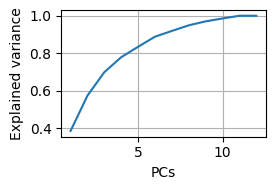

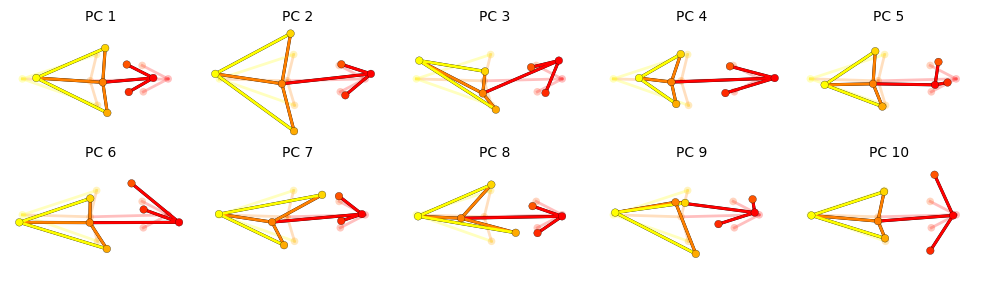

In [17]:
kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config)

In [18]:
kpms.update_config(project_dir, latent_dim=7)
config = kpms.load_config(project_dir)

## C. Model fitting

**Fitting a keypoint-MoSeq model involves:**

1. Initialization: Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA.
2. Fitting an AR-HMM: The AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling.
3. Fitting the full model: All parameters, including both the AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. pose trajectories) are iteratively updated through Gibbs sampling. This step is especially useful for noisy data.
4. Extracting model results: The learned states of the model are parsed and saved to disk for vizualization and downstream analysis.
5. [Optional] Applying the trained model: The learned model parameters can be used to infer a syllable sequences for additional data.

**Setting kappa**

Most users will need to adjust the kappa hyperparameter to achieve the desired distribution of syllable durations. For this tutorial we chose kappa values that yielded a median syllable duration of 400ms (12 frames). Most users will need to tune kappa to their particular dataset. Higher values of kappa lead to longer syllables. You will need to pick two kappas: one for AR-HMM fitting and one for the full model.

- We recommend iteratively updating kappa and refitting the model until the target syllable time-scale is attained.
- Model fitting can be stopped at any time by interrupting the kernel, and then restarted with a new kappa value.
- The full model will generally require a lower value of kappa to yield the same target syllable durations.
- To adjust the value of kappa in the model, use kpms.update_hypparams as shown below. Note that this command only changes kappa in the model dictionary, not the kappa value in the config file. The value in the config is only used during model initialization.



### C1. Initialize the model

In [14]:
# initialize the model
model = kpms.init_model(data, pca=pca, **config)

In [19]:
# optionally modify kappa
default_kappa = 1e6
ar_kappa = 1e10
model = kpms.update_hypparams(model, kappa=ar_kappa)

### C2. Fitting an AR-HMM

In addition to fitting an AR-HMM, the function below:

- generates a name for the model and a corresponding directory in project_dir
- saves a checkpoint every 10 iterations from which fitting can be restarted
- plots the progress of fitting every 10 iterations, including
    - the distributions of syllable frequencies and durations for the most recent iteration
    - the change in median syllable duration across fitting iterations
    - a sample of the syllable sequence across iterations in a random window


Outputs will be saved to /mnt/Data/EPM/MouseTopDown-
Loukia-2022-09-13_keypoint-moseq/2024_09_19-15_54_42


 20%|██████▊                            | 10/51 [00:46<03:25,  5.01s/it]

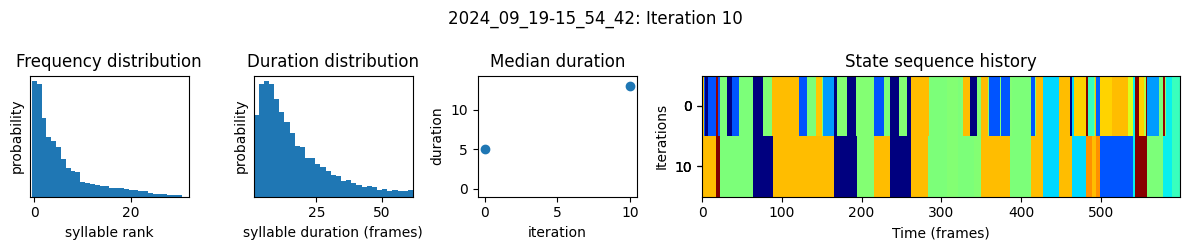

 39%|█████████████▋                     | 20/51 [01:26<01:44,  3.35s/it]

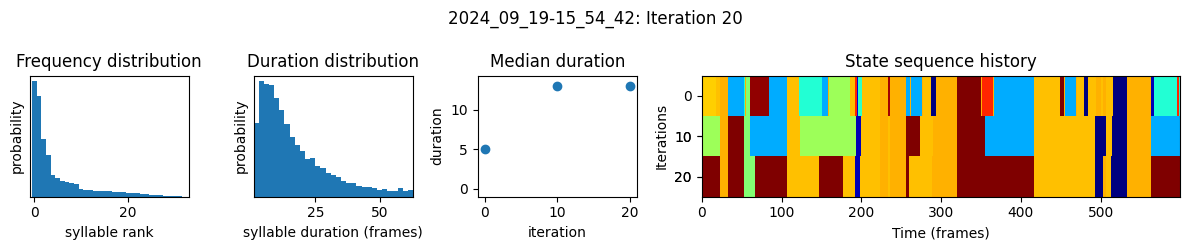

 59%|████████████████████▌              | 30/51 [02:14<01:45,  5.03s/it]

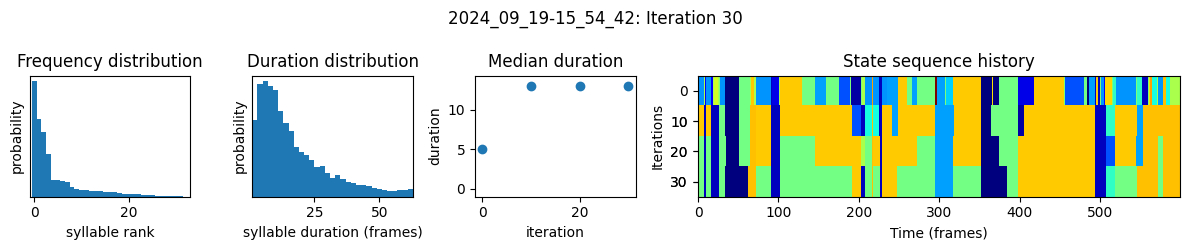

 78%|███████████████████████████▍       | 40/51 [03:18<01:04,  5.88s/it]

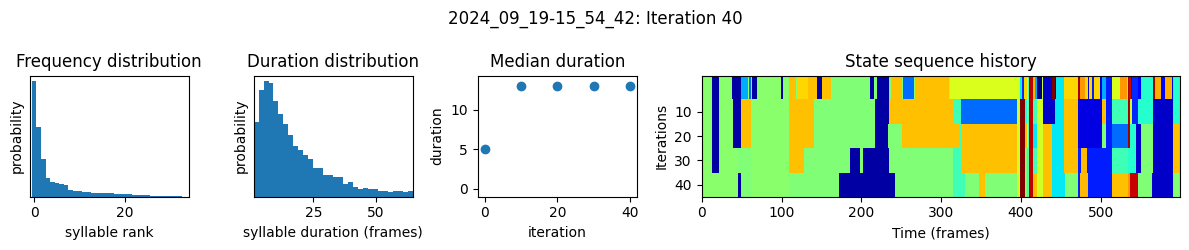

 98%|██████████████████████████████████▎| 50/51 [04:21<00:06,  6.03s/it]

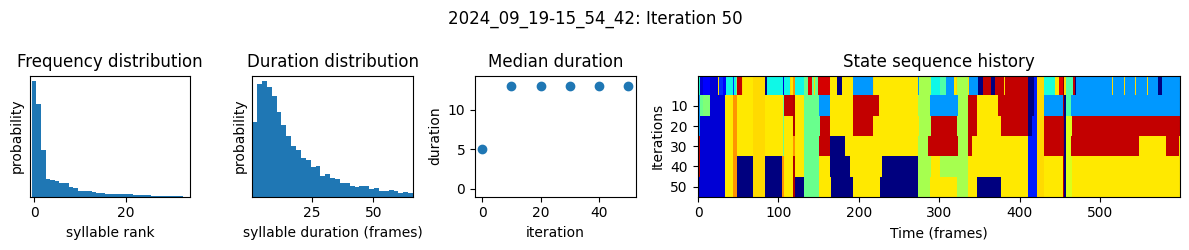

100%|███████████████████████████████████| 51/51 [04:25<00:00,  5.20s/it]


In [20]:
num_ar_iters = 50

model, model_name = kpms.fit_model(
    model,
    data,
    metadata,
    project_dir,
    ar_only=True,
    num_iters=num_ar_iters,
    save_every_n_iters=10,
)

### C3. Fitting the full model

The following code fits a full keypoint-MoSeq model using the results of AR-HMM fitting for initialization. If using your own data, you may need to try a few values of kappa at this step.

Outputs will be saved to /mnt/Data/EPM/MouseTopDown-
Loukia-2022-09-13_keypoint-moseq/2024_09_19-15_54_42


  5%|█▌                              | 25/501 [10:06<3:10:26, 24.00s/it]

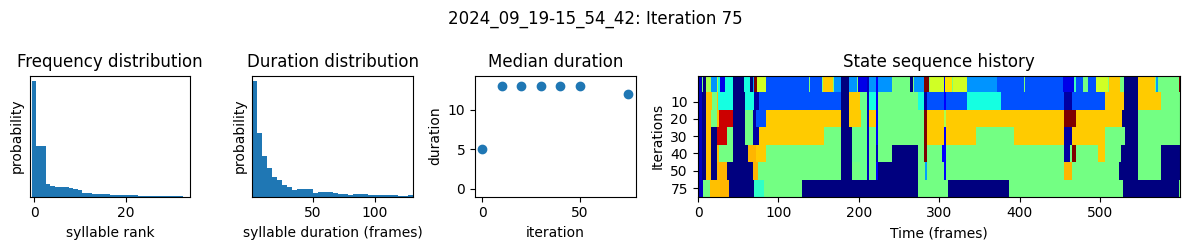

 10%|███▏                            | 50/501 [20:23<3:06:54, 24.87s/it]

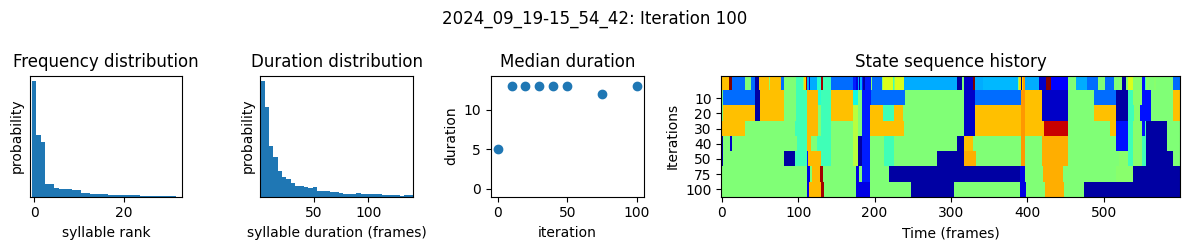

 15%|████▊                           | 75/501 [30:38<2:51:11, 24.11s/it]

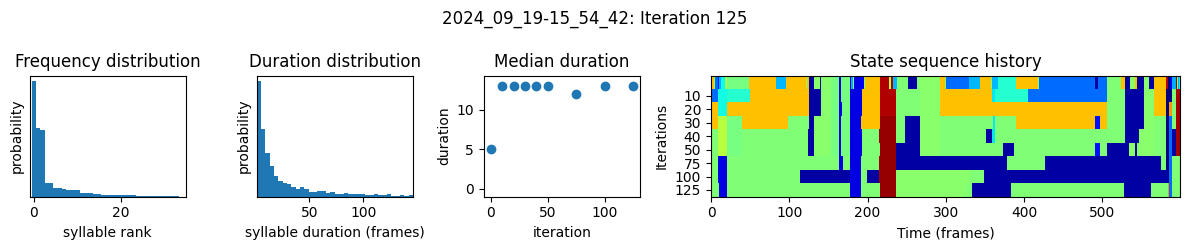

 20%|██████▏                        | 100/501 [40:45<2:38:22, 23.70s/it]

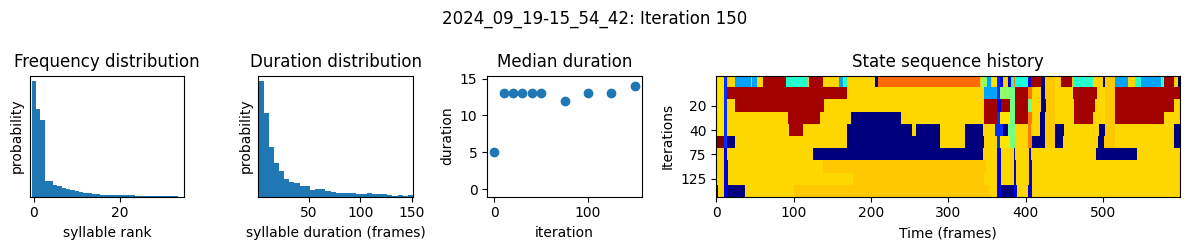

 25%|███████▋                       | 125/501 [49:25<2:07:46, 20.39s/it]

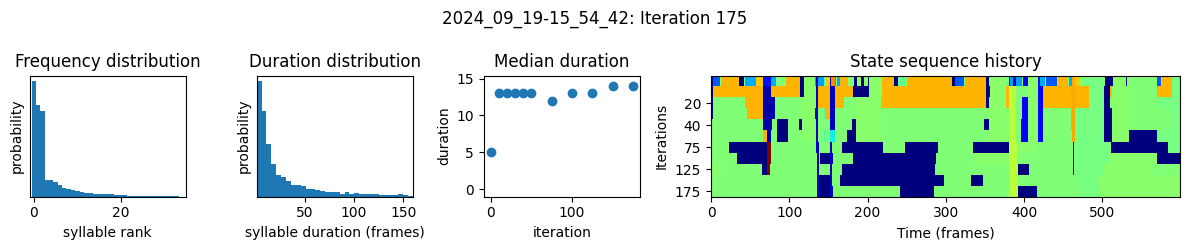

 30%|█████████▎                     | 150/501 [58:00<1:59:20, 20.40s/it]

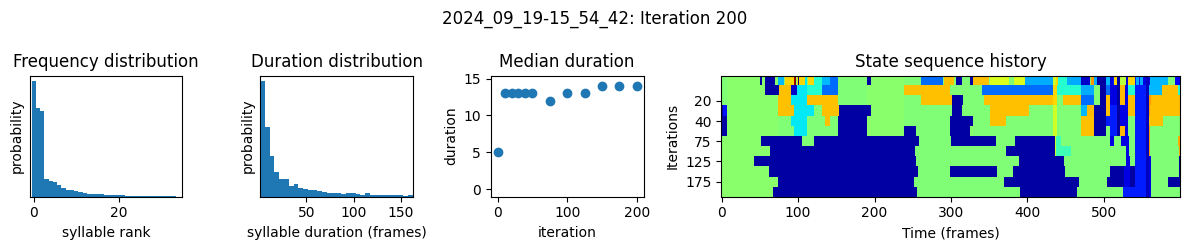

 35%|██████████▏                  | 175/501 [1:06:34<1:50:49, 20.40s/it]

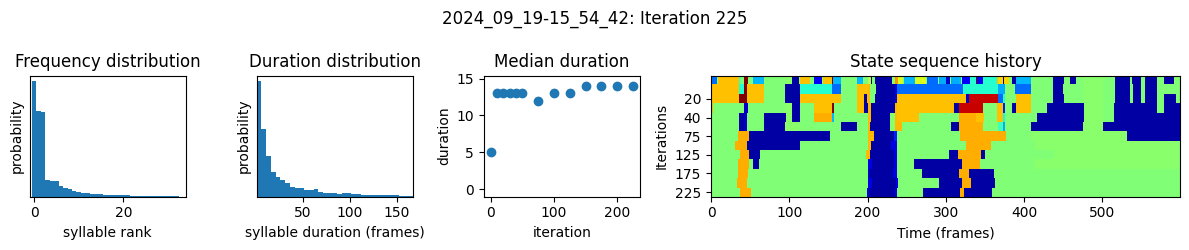

 40%|███████████▌                 | 200/501 [1:15:09<1:42:15, 20.38s/it]

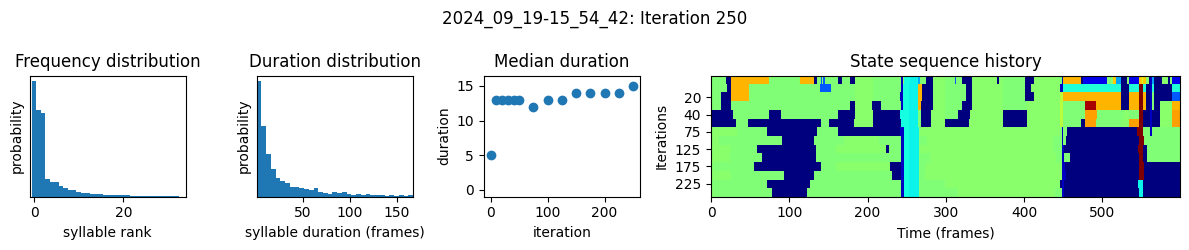

 45%|█████████████                | 225/501 [1:23:44<1:33:48, 20.39s/it]

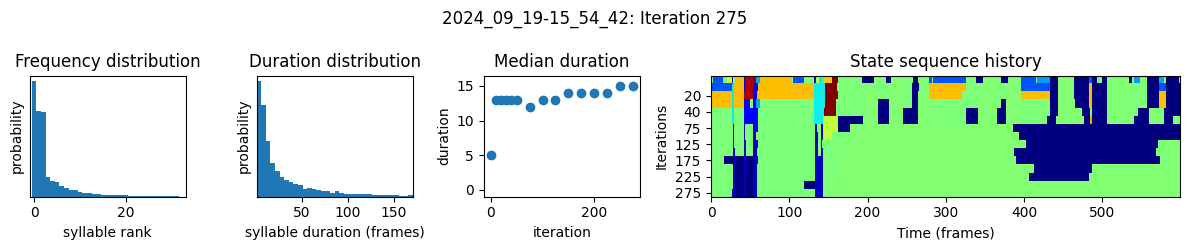

 50%|██████████████▍              | 250/501 [1:32:09<1:25:05, 20.34s/it]

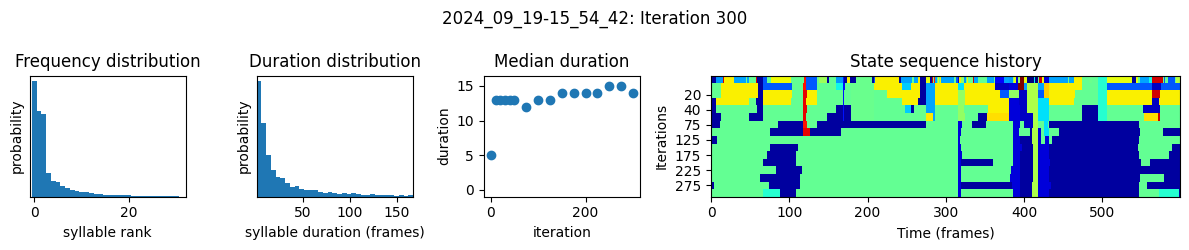

 55%|███████████████▉             | 275/501 [1:40:44<1:16:58, 20.44s/it]

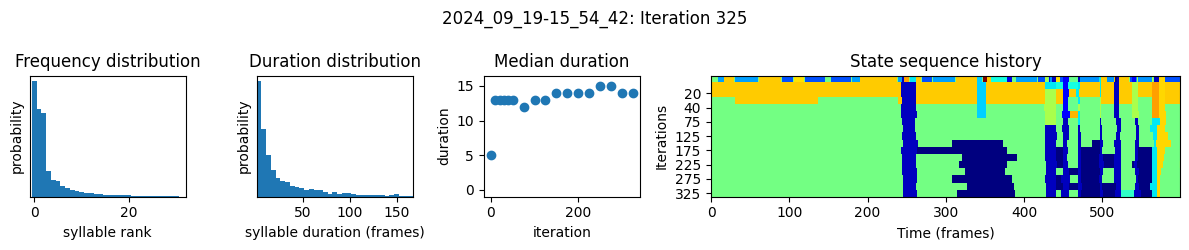

 60%|█████████████████▎           | 300/501 [1:49:18<1:08:22, 20.41s/it]

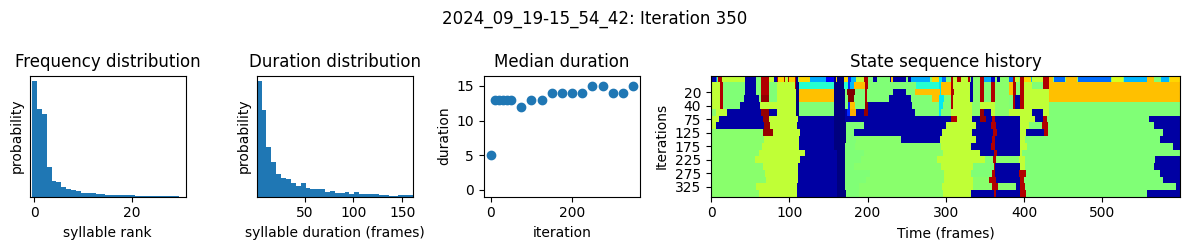

 65%|████████████████████           | 325/501 [1:57:54<59:50, 20.40s/it]

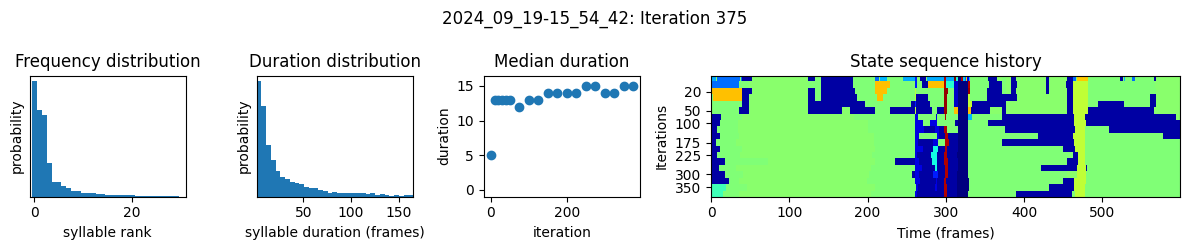

 70%|█████████████████████▋         | 350/501 [2:06:21<51:17, 20.38s/it]

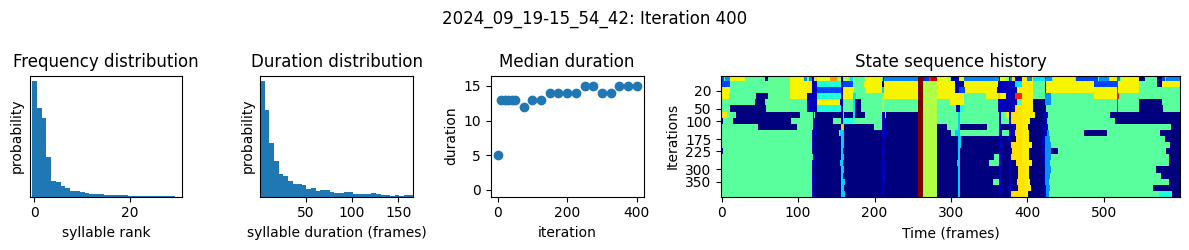

 75%|███████████████████████▏       | 375/501 [2:14:52<42:42, 20.34s/it]

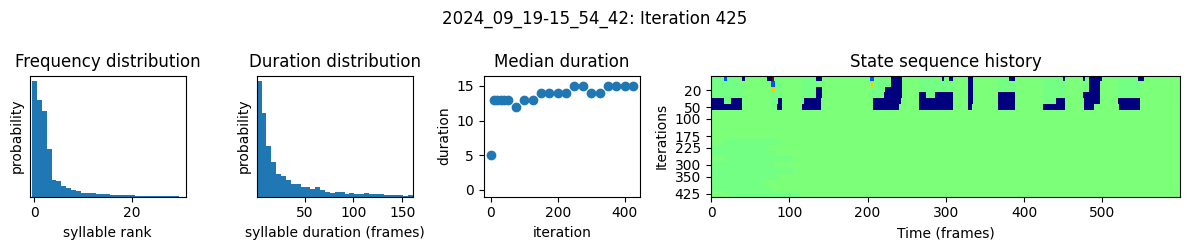

 80%|████████████████████████▊      | 400/501 [2:23:26<34:21, 20.41s/it]

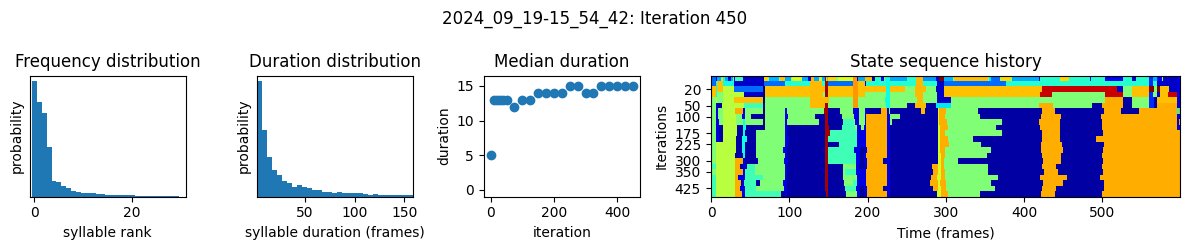

 85%|██████████████████████████▎    | 425/501 [2:31:50<24:32, 19.37s/it]

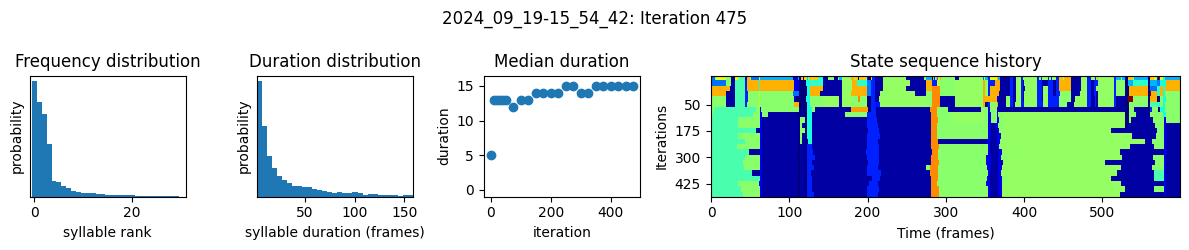

 90%|███████████████████████████▊   | 450/501 [2:40:19<17:19, 20.39s/it]

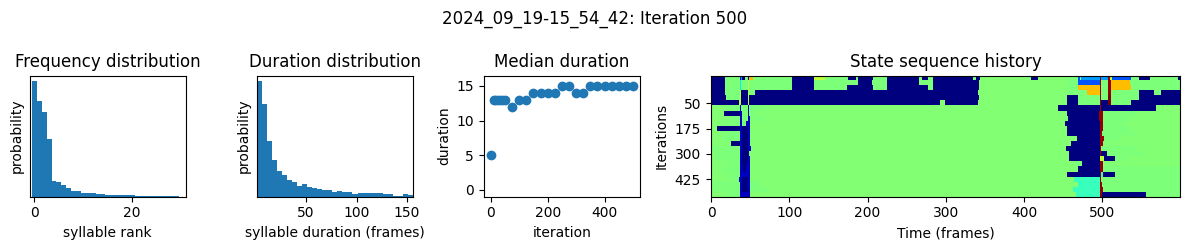

 95%|█████████████████████████████▍ | 475/501 [2:48:48<08:50, 20.40s/it]

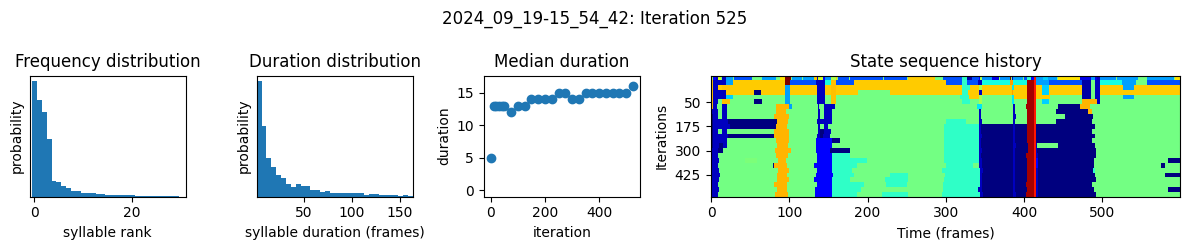

100%|██████████████████████████████▉| 500/501 [2:56:44<00:20, 20.19s/it]

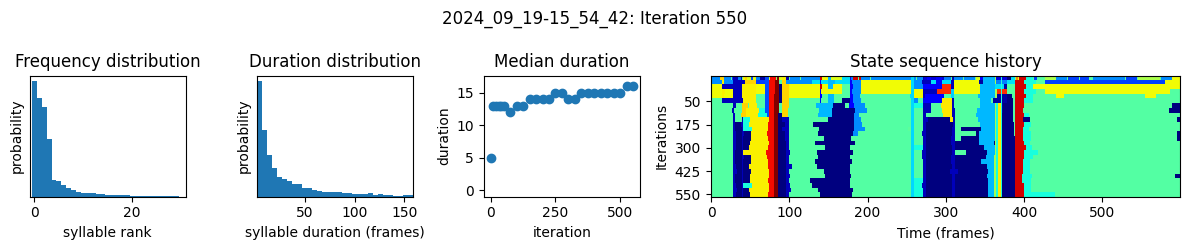

100%|███████████████████████████████| 501/501 [2:57:09<00:00, 21.22s/it]


In [26]:
# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
full_kappa = 1e5
model = kpms.update_hypparams(model, kappa=full_kappa)

# run fitting for an additional 500 iters
model = kpms.fit_model(
    model, 
    data,
    metadata,
    project_dir,
    model_name,
    ar_only=False, 
    start_iter=current_iter,
    num_iters=current_iter+500,
    parallel_message_passing=False,  # NECESSARY to prevent OOM errors
)[0]

### C4. Sort syllables by frequency

Permute the states and parameters of a saved checkpoint so that syllables are labeled in order of frequency (i.e. so that `0` is the most frequent, `1` is the second most, and so on). 

In [27]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name);

Reindexing: 100%|███████████| 26/26 [00:04<00:00,  5.57model snapshot/s]


### C5. Extract model results
Parse the modeling results and save them to `{project_dir}/{model_name}/results.h5`. The results are stored as follows, and can be reloaded at a later time using `kpms.load_results`. Check the docs for an [in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).

```bash
 results.h5
    ├──recording_name1
    │  ├──syllable      # syllable labels (z)
    │  ├──latent_state  # inferred low-dim pose state (x)
    │  ├──centroid      # inferred centroid (v)
    │  └──heading       # inferred heading (h)
    ⋮
```

In [28]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

Saved results to /mnt/Data/EPM/MouseTopDown-
Loukia-2022-09-13_keypoint-moseq/2024_09_19-15_54_42/results.h5


After extracting to an h5 file, the results can also be saved as csv files. A separate file will be created for each recording and saved to `{project_dir}/{model_name}/results/`. 

In [31]:
kpms.save_results_as_csv(results, project_dir, model_name)

Saving to csv: 100%|████████████████████| 10/10 [00:07<00:00,  1.38it/s]


## D. Visualize results
### D1. Trajectory plots
Generate plots showing the median trajectory of poses associated with each given syllable. 

Saving trajectory plots to /mnt/Data/EPM/MouseTopDown-Loukia-2022-09-13_keypoint-moseq/2024_09_19-15_54_42/trajectory_plots


Generating trajectory plots: 100%|████████| 8/8 [00:22<00:00,  2.83s/it]


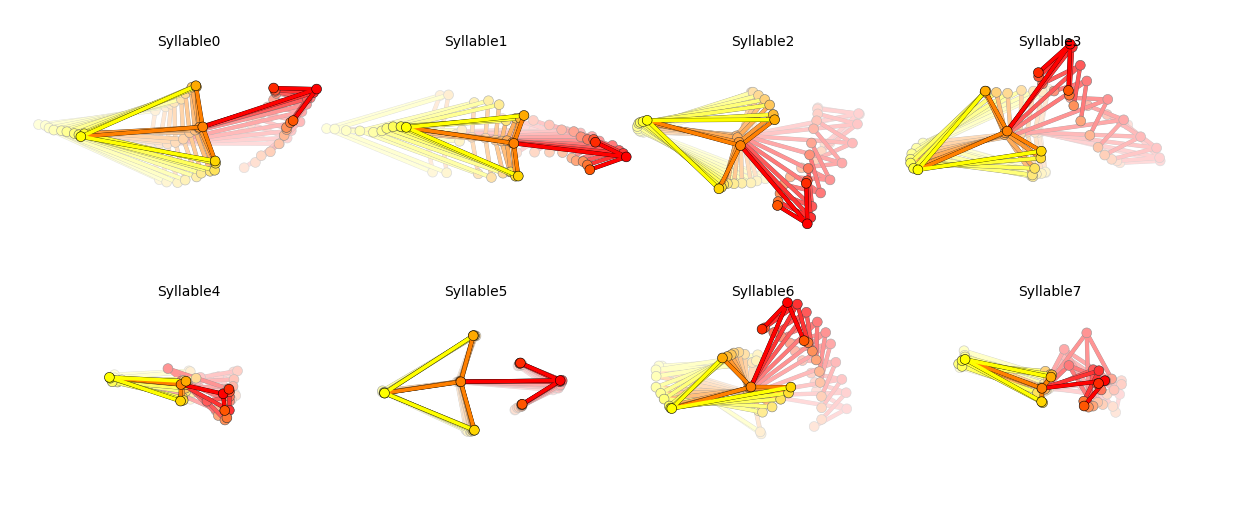

In [39]:
kpms.generate_trajectory_plots(
    coordinates, results, project_dir, model_name, fps=30, **config,
)


### D2. Grid movies
Generate video clips showing examples of each syllable.

In [40]:
kpms.generate_grid_movies(
    results,
    project_dir,
    model_name,
    coordinates=coordinates,
    rows=4,
    cols=4,
    fps=30,
    **config
);

Writing grid movies to /mnt/Data/EPM/MouseTopDown-Loukia-2022-09-13_keypoint-moseq/2024_09_19-15_54_42/grid_movies
Using window size of 256 pixels


Generating grid movies: 100%|███████████| 15/15 [06:55<00:00, 27.67s/it]


### D3. Syllable Dendrogram
Plot a dendrogram representing distances between each syllable's median trajectory.

Saving dendrogram plot to /mnt/Data/EPM/MouseTopDown-Loukia-2022-09-13_keypoint-moseq/2024_09_19-15_54_42/similarity_dendrogram


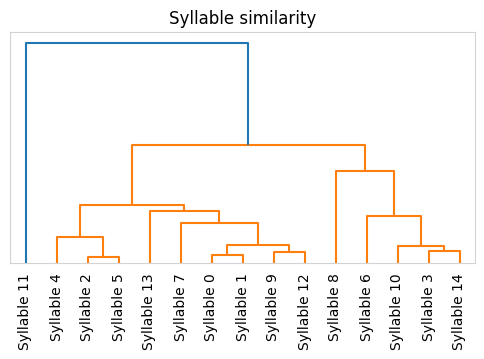

In [41]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config)